# Practice Lab: Advice for Applying Machine Learning
In this lab, you will explore techniques to evaluate and improve your machine learning models.

# Outline
- [ 1 - Packages ](#1)
- [ 2 - Evaluating a Learning Algorithm (Polynomial Regression)](#2)
  - [ 2.1 Splitting your data set](#2.1)
  - [ 2.2 Error calculation for model evaluation, linear regression](#2.2)
    - [ Exercise 1](#ex01)
  - [ 2.3 Compare performance on training and test data](#2.3)
- [ 3 - Bias and Variance<img align="Right" src="./images/C2_W3_BiasVarianceDegree.png"  style=" width:500px; padding: 10px 20px ; "> ](#3)
  - [ 3.1 Plot Train, Cross-Validation, Test](#3.1)
  - [ 3.2 Finding the optimal degree](#3.2)
  - [ 3.3 Tuning Regularization.](#3.3)
  - [ 3.4 Getting more data: Increasing Training Set Size (m)](#3.4)
- [ 4 - Evaluating a Learning Algorithm (Neural Network)](#4)
  - [ 4.1 Data Set](#4.1)
  - [ 4.2 Evaluating categorical model by calculating classification error](#4.2)
    - [ Exercise 2](#ex02)
- [ 5 - Model Complexity](#5)
  - [ Exercise 3](#ex03)
  - [ 5.1 Simple model](#5.1)
    - [ Exercise 4](#ex04)
- [ 6 - Regularization](#6)
  - [ Exercise 5](#ex05)
- [ 7 - Iterate to find optimal regularization value](#7)
  - [ 7.1 Test](#7.1)


<a name="1"></a>
## 1 - Packages 

First, let's run the cell below to import all the packages that you will need during this assignment.
- [numpy](https://numpy.org/) is the fundamental package for scientific computing Python.
- [matplotlib](http://matplotlib.org) is a popular library to plot graphs in Python.
- [scikitlearn](https://scikit-learn.org/stable/) is a basic library for data mining
- [tensorflow](https://www.tensorflow.org/) a popular platform for machine learning.

In [1]:
import numpy as np
%matplotlib widget
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.activations import relu,linear
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)

from public_tests_a1 import * 

tf.keras.backend.set_floatx('float64')
from assigment_utils import *

tf.autograph.set_verbosity(0)

2023-11-29 17:38:45.935944: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-29 17:38:45.968818: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-29 17:38:46.117815: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-29 17:38:46.117842: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-29 17:38:46.118718: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

<a name="2"></a>
## 2 - Evaluating a Learning Algorithm (Polynomial Regression)

<img align="Right" src="./images/C2_W3_TrainingVsNew.png"  style=" width:350px; padding: 10px 20px ; "> Let's say you have created a machine learning model and you find it *fits* your training data very well. You're done? Not quite. The goal of creating the model was to be able to predict values for <span style="color:blue">*new* </span> examples. 

How can you test your model's performance on new data before deploying it?   
The answer has two parts:
* Split your original data set into "Training" and "Test" sets. 
    * Use the training data to fit the parameters of the model
    * Use the test data to evaluate the model on *new* data
* Develop an error function to evaluate your model.

<a name="2.1"></a>
### 2.1 Splitting your data set
Lectures advised reserving 20-40% of your data set for testing. Let's use an `sklearn` function [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) to perform the split. Double-check the shapes after running the following cell.

In [2]:
# Generate some data
X,y,x_ideal,y_ideal = gen_data(18, 2, 0.7)
print("X.shape", X.shape, "y.shape", y.shape)

#split the data using sklearn routine 
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33, random_state=1)
print("X_train.shape", X_train.shape, "y_train.shape", y_train.shape)
print("X_test.shape", X_test.shape, "y_test.shape", y_test.shape)

X.shape (18,) y.shape (18,)
X_train.shape (12,) y_train.shape (12,)
X_test.shape (6,) y_test.shape (6,)


#### 2.1.1 Plot Train, Test sets
You can see below the data points that will be part of training (in red) are intermixed with those that the model is not trained on (test). This particular data set is a quadratic function with noise added. The "ideal" curve is shown for reference.

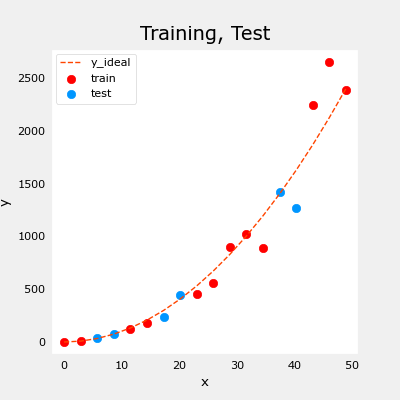

In [3]:
fig, ax = plt.subplots(1,1,figsize=(4,4))
ax.plot(x_ideal, y_ideal, "--", color = "orangered", label="y_ideal", lw=1)
ax.set_title("Training, Test",fontsize = 14)
ax.set_xlabel("x")
ax.set_ylabel("y")

ax.scatter(X_train, y_train, color = "red",           label="train")
ax.scatter(X_test, y_test,   color = dlc["dlblue"],   label="test")
ax.legend(loc='upper left')
plt.show()

<a name="2.2"></a>
### 2.2 Error calculation for model evaluation, linear regression
When *evaluating* a linear regression model, you average the squared error difference of the predicted values and the target values.

$$ J_\text{test}(\mathbf{w},b) = 
            \frac{1}{2m_\text{test}}\sum_{i=0}^{m_\text{test}-1} ( f_{\mathbf{w},b}(\mathbf{x}^{(i)}_\text{test}) - y^{(i)}_\text{test} )^2 
            \tag{1}
$$

<a name="ex01"></a>
### Exercise 1

Below, create a function to evaluate the error on a data set for a linear regression model.

In [4]:
# UNQ_C1
# GRADED CELL: eval_mse
def eval_mse(y, yhat):
    """ 
    Calculate the mean squared error on a data set.
    Args:
      y    : (ndarray  Shape (m,) or (m,1))  target value of each example
      yhat : (ndarray  Shape (m,) or (m,1))  predicted value of each example
    Returns:
      err: (scalar)             
    """
    m = len(y)
    err = 0.0
    for i in range(m):
    ### START CODE HERE ### 
        err+=(y[i]-yhat[i])**2
    ### END CODE HERE ### 
    err/= 2*m
    return(err)

In [5]:
y_hat = np.array([2.4, 4.2])
y_tmp = np.array([2.3, 4.1])
eval_mse(y_hat, y_tmp)

# BEGIN UNIT TEST
test_eval_mse(eval_mse)   
# END UNIT TEST

 All tests passed.


<details>
  <summary><font size="3" color="darkgreen"><b>Click for hints</b></font></summary>

    
```python
def eval_mse(y, yhat):
    """ 
    Calculate the mean squared error on a data set.
    Args:
      y    : (ndarray  Shape (m,) or (m,1))  target value of each example
      yhat : (ndarray  Shape (m,) or (m,1))  predicted value of each example
    Returns:
      err: (scalar)             
    """
    m = len(y)
    err = 0.0
    for i in range(m):
        err_i  = ( (yhat[i] - y[i])**2 ) 
        err   += err_i                                                                
    err = err / (2*m)                    
    return(err)
``` 

<a name="2.3"></a>
### 2.3 Compare performance on training and test data
Let's build a high degree polynomial model to minimize training error. This will use the linear_regression functions from `sklearn`. The code is in the imported utility file if you would like to see the details. The steps below are:
* create and fit the model. ('fit' is another name for training or running gradient descent).
* compute the error on the training data.
* compute the error on the test data.

In [6]:
# create a model in sklearn, train on training data
degree = 10
lmodel = lin_model(degree)
lmodel.fit(X_train, y_train)

# predict on training data, find training error
yhat = lmodel.predict(X_train)
err_train = lmodel.mse(y_train, yhat)

# predict on test data, find error
yhat = lmodel.predict(X_test)
err_test = lmodel.mse(y_test, yhat)

The computed error on the training set is substantially less than that of the test set. 

In [7]:
print(f"training err {err_train:0.2f}, test err {err_test:0.2f}")

training err 58.01, test err 171215.01


The following plot shows why this is. The model fits the training data very well. To do so, it has created a complex function. The test data was not part of the training and the model does a poor job of predicting on this data.  
This model would be described as 1) is overfitting, 2) has high variance 3) 'generalizes' poorly.

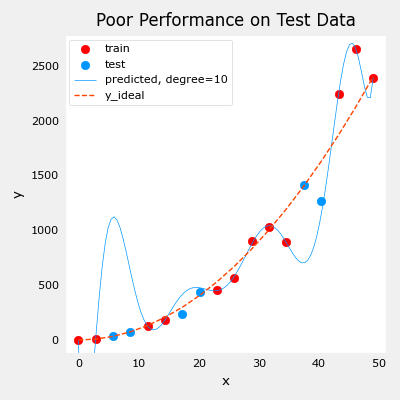

In [8]:
# plot predictions over data range 
x = np.linspace(0,int(X.max()),100)  # predict values for plot
y_pred = lmodel.predict(x).reshape(-1,1)

plt_train_test(X_train, y_train, X_test, y_test, x, y_pred, x_ideal, y_ideal, degree)

The test set error shows this model will not work well on new data. If you use the test error to guide improvements in the model, then the model will perform well on the test data... but the test data was meant to represent *new* data.
You need yet another set of data to test new data performance.

The proposal made during lecture is to separate data into three groups. The distribution of training, cross-validation and test sets shown in the below table is a typical distribution, but can be varied depending on the amount of data available.

| data             | % of total | Description |
|------------------|:----------:|:---------|
| training         | 60         | Data used to tune model parameters $w$ and $b$ in training or fitting |
| cross-validation | 20         | Data used to tune other model parameters like degree of polynomial, regularization or the architecture of a neural network.|
| test             | 20         | Data used to test the model after tuning to gauge performance on new data |


Let's generate three data sets below. We'll once again use `train_test_split` from `sklearn` but will call it twice to get three splits:

In [10]:
# Generate  data
X,y, x_ideal,y_ideal = gen_data(40, 5, 0.7)
print("X.shape", X.shape, "y.shape", y.shape)

#split the data using sklearn routine 
X_train, X_, y_train, y_ = train_test_split(X,y,test_size=0.40, random_state=1)
X_cv, X_test, y_cv, y_test = train_test_split(X_,y_,test_size=0.50, random_state=1)
print("X_train.shape", X_train.shape, "y_train.shape", y_train.shape)
print("X_cv.shape", X_cv.shape, "y_cv.shape", y_cv.shape)
print("X_test.shape", X_test.shape, "y_test.shape", y_test.shape)

X.shape (40,) y.shape (40,)
X_train.shape (24,) y_train.shape (24,)
X_cv.shape (8,) y_cv.shape (8,)
X_test.shape (8,) y_test.shape (8,)


<a name="3"></a>
## 3 - Bias and Variance<img align="Right" src="./images/C2_W3_BiasVarianceDegree.png"  style=" width:500px; padding: 10px 20px ; "> 
 Above, it was clear the degree of the polynomial model was too high. How can you choose a good value? It turns out, as shown in the diagram, the training and cross-validation performance can provide guidance. By trying a range of degree values, the training and cross-validation performance can be evaluated. As the degree becomes too large, the cross-validation performance will start to degrade relative to the training performance. Let's try this on our example.

<a name="3.1"></a>
### 3.1 Plot Train, Cross-Validation, Test
You can see below the datapoints that will be part of training (in red) are intermixed with those that the model is not trained on (test and cv).

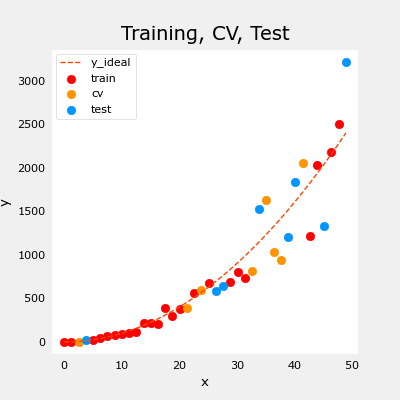

In [11]:
fig, ax = plt.subplots(1,1,figsize=(4,4))
ax.plot(x_ideal, y_ideal, "--", color = "orangered", label="y_ideal", lw=1)
ax.set_title("Training, CV, Test",fontsize = 14)
ax.set_xlabel("x")
ax.set_ylabel("y")

ax.scatter(X_train, y_train, color = "red",           label="train")
ax.scatter(X_cv, y_cv,       color = dlc["dlorange"], label="cv")
ax.scatter(X_test, y_test,   color = dlc["dlblue"],   label="test")
ax.legend(loc='upper left')
plt.show()

<a name="3.2"></a>
### 3.2 Finding the optimal degree
In previous labs, you found that you could create a model capable of fitting complex curves by utilizing a polynomial (See Course1, Week2 Feature Engineering and Polynomial Regression Lab).  Further, you demonstrated that by increasing the *degree* of the polynomial, you could *create* overfitting. (See Course 1, Week3, Over-Fitting Lab). Let's use that knowledge here to test our ability to tell the difference between over-fitting and under-fitting.

Let's train the model repeatedly, increasing the degree of the polynomial each iteration. Here, we're going to use the [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression) linear regression model for speed and simplicity.

In [14]:
max_degree = 9
err_train = np.zeros(max_degree)    
err_cv = np.zeros(max_degree)      
x = np.linspace(0,int(X.max()),100)  
y_pred = np.zeros((100,max_degree))  #columns are lines to plot

for degree in range(max_degree):
    lmodel = lin_model(degree+1)
    lmodel.fit(X_train, y_train)
    yhat = lmodel.predict(X_train)
    err_train[degree] = lmodel.mse(y_train, yhat)
    yhat = lmodel.predict(X_cv)
    err_cv[degree] = lmodel.mse(y_cv, yhat)
    y_pred[:,degree] = lmodel.predict(x)
    
optimal_degree = np.argmin(err_cv)+1

<font size="4">Let's plot the result:</font>

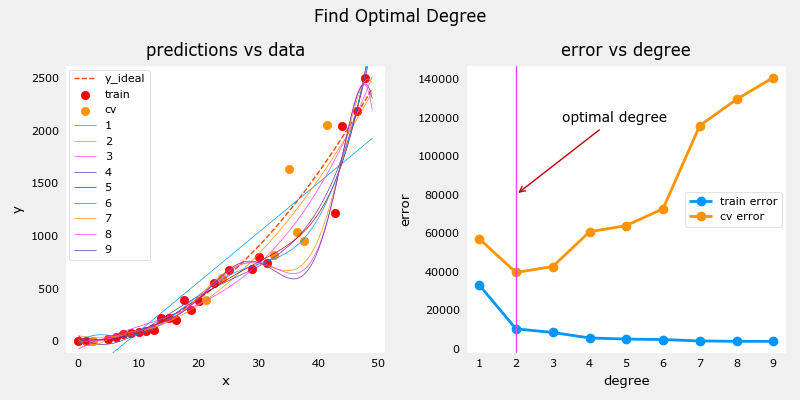

In [15]:
plt.close("all")
plt_optimal_degree(X_train, y_train, X_cv, y_cv, x, y_pred, x_ideal, y_ideal, 
                   err_train, err_cv, optimal_degree, max_degree)

The plot above demonstrates that separating data into two groups, data the model is trained on and data the model has not been trained on, can be used to determine if the model is underfitting or overfitting. In our example, we created a variety of models varying from underfitting to overfitting by increasing the degree of the polynomial used. 
- On the left plot, the solid lines represent the predictions from these models. A polynomial model with degree 1 produces a straight line that intersects very few data points, while the maximum degree hews very closely to every data point. 
- on the right:
    - the error on the trained data (blue) decreases as the model complexity increases as expected
    - the error of the cross-validation data decreases initially as the model starts to conform to the data, but then increases as the model starts to over-fit on the training data (fails to *generalize*).     
    
It's worth noting that the curves in these examples as not as smooth as one might draw for a lecture. It's clear the specific data points assigned to each group can change your results significantly. The general trend is what is important.

<a name="3.3"></a>
### 3.3 Tuning Regularization.
In previous labs, you have utilized *regularization* to reduce overfitting. Similar to degree, one can use the same methodology to tune the regularization parameter lambda ($\lambda$).

Let's demonstrate this by starting with a high degree polynomial and varying the regularization parameter.

In [16]:
lambda_range = np.array([0.0, 1e-6, 1e-5, 1e-4,1e-3,1e-2, 1e-1,1,10,100])
num_steps = len(lambda_range)
degree = 10
err_train = np.zeros(num_steps)    
err_cv = np.zeros(num_steps)       
x = np.linspace(0,int(X.max()),100) 
y_pred = np.zeros((100,num_steps))  #columns are lines to plot

for i in range(num_steps):
    lambda_= lambda_range[i]
    lmodel = lin_model(degree, regularization=True, lambda_=lambda_)
    lmodel.fit(X_train, y_train)
    yhat = lmodel.predict(X_train)
    err_train[i] = lmodel.mse(y_train, yhat)
    yhat = lmodel.predict(X_cv)
    err_cv[i] = lmodel.mse(y_cv, yhat)
    y_pred[:,i] = lmodel.predict(x)
    
optimal_reg_idx = np.argmin(err_cv) 

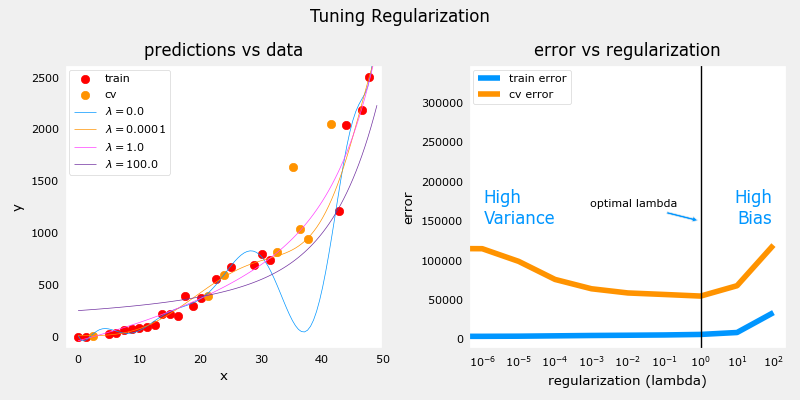

In [17]:
plt.close("all")
plt_tune_regularization(X_train, y_train, X_cv, y_cv, x, y_pred, err_train, err_cv, optimal_reg_idx, lambda_range)

Above, the plots show that as regularization increases, the model moves from a high variance (overfitting) model to a high bias (underfitting) model. The vertical line in the right plot shows the optimal value of lambda. In this example, the polynomial degree was set to 10. 

<a name="3.4"></a>
### 3.4 Getting more data: Increasing Training Set Size (m)
When a model is overfitting (high variance), collecting additional data can improve performance. Let's try that here.

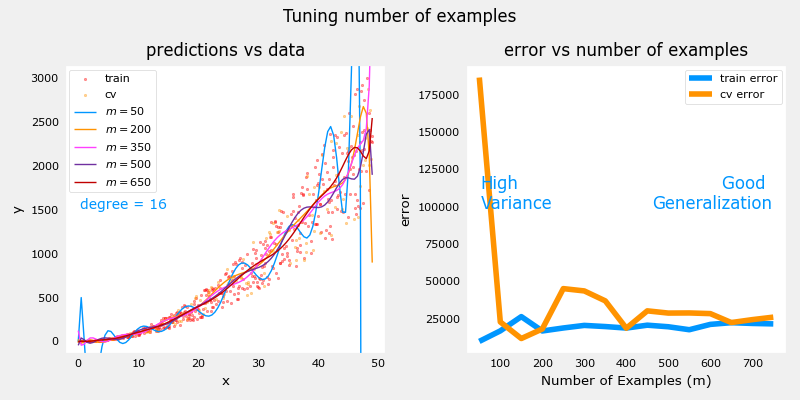

In [18]:
X_train, y_train, X_cv, y_cv, x, y_pred, err_train, err_cv, m_range,degree = tune_m()
plt_tune_m(X_train, y_train, X_cv, y_cv, x, y_pred, err_train, err_cv, m_range, degree)

The above plots show that when a model has high variance and is overfitting, adding more examples improves performance. Note the curves on the left plot. The final curve with the highest value of $m$ is a smooth curve that is in the center of the data. On the right, as the number of examples increases, the performance of the training set and cross-validation set converge to similar values. Note that the curves are not as smooth as one might see in a lecture. That is to be expected. The trend remains clear: more data improves generalization. 

> Note that adding more examples when the model has high bias (underfitting) does not improve performance.


<a name="4"></a>
## 4 - Evaluating a Learning Algorithm (Neural Network)
Above, you tuned aspects of a polynomial regression model. Here, you will work with a neural network model. Let's start by creating a classification data set. 

<a name="4.1"></a>
### 4.1 Data Set
Run the cell below to generate a data set and split it into training, cross-validation (CV) and test sets. In this example, we're increasing the percentage of cross-validation data points for emphasis.  

In [19]:
# Generate and split data set
X, y, centers, classes, std = gen_blobs() 

# split the data. Large CV population for demonstration
X_train, X_, y_train, y_ = train_test_split(X,y,test_size=0.50, random_state=1)
X_cv, X_test, y_cv, y_test = train_test_split(X_,y_,test_size=0.20, random_state=1)
print("X_train.shape:", X_train.shape, "X_cv.shape:", X_cv.shape, "X_test.shape:", X_test.shape)

X_train.shape: (400, 2) X_cv.shape: (320, 2) X_test.shape: (80, 2)


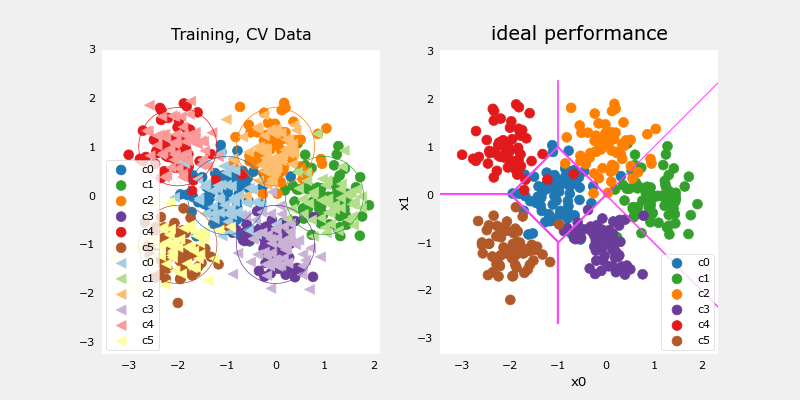

In [20]:
plt_train_eq_dist(X_train, y_train,classes, X_cv, y_cv, centers, std)

Above, you can see the data on the left. There are six clusters identified by color. Both training points (dots) and cross-validataion points (triangles) are shown. The interesting points are those that fall in ambiguous locations where either cluster might consider them members. What would you expect a neural network model to do? What would be an example of overfitting? underfitting?  
On the right is an example of an 'ideal' model, or a model one might create knowing the source of the data. The lines represent 'equal distance' boundaries where the distance between center points is equal. It's worth noting that this model would "misclassify" roughly 8% of the total data set.

<a name="4.2"></a>
### 4.2 Evaluating categorical model by calculating classification error
The evaluation function for categorical models used here is simply the fraction of incorrect predictions:  
$$ J_{cv} =\frac{1}{m}\sum_{i=0}^{m-1} 
\begin{cases}
    1, & \text{if $\hat{y}^{(i)} \neq y^{(i)}$}\\
    0, & \text{otherwise}
\end{cases}
$$

<a name="ex02"></a>
### Exercise 2

Below, complete the routine to calculate classification error. Note, in this lab, target values are the index of the category and are not [one-hot encoded](https://en.wikipedia.org/wiki/One-hot).

In [21]:
# UNQ_C2
# GRADED CELL: eval_cat_err
def eval_cat_err(y, yhat):
    """ 
    Calculate the categorization error
    Args:
      y    : (ndarray  Shape (m,) or (m,1))  target value of each example
      yhat : (ndarray  Shape (m,) or (m,1))  predicted value of each example
    Returns:|
      cerr: (scalar)             
    """
    m = len(y)
    incorrect = 0
    for i in range(m):
    ### START CODE HERE ### 
        if(yhat[i]!=y[i]):
            incorrect+=1
    ### END CODE HERE ### 
    cerr=incorrect/m
    return(cerr)

In [22]:
y_hat = np.array([1, 2, 0])
y_tmp = np.array([1, 2, 3])
print(f"categorization error {np.squeeze(eval_cat_err(y_hat, y_tmp)):0.3f}, expected:0.333" )
y_hat = np.array([[1], [2], [0], [3]])
y_tmp = np.array([[1], [2], [1], [3]])
print(f"categorization error {np.squeeze(eval_cat_err(y_hat, y_tmp)):0.3f}, expected:0.250" )

# BEGIN UNIT TEST  
test_eval_cat_err(eval_cat_err)
# END UNIT TEST
# BEGIN UNIT TEST  
test_eval_cat_err(eval_cat_err)
# END UNIT TEST

categorization error 0.333, expected:0.333
categorization error 0.250, expected:0.250
 All tests passed.
 All tests passed.


<details>
  <summary><font size="3" color="darkgreen"><b>Click for hints</b></font></summary>
    
```python
def eval_cat_err(y, yhat):
    """ 
    Calculate the categorization error
    Args:
      y    : (ndarray  Shape (m,) or (m,1))  target value of each example
      yhat : (ndarray  Shape (m,) or (m,1))  predicted value of each example
    Returns:|
      cerr: (scalar)             
    """
    m = len(y)
    incorrect = 0
    for i in range(m):
        if yhat[i] != y[i]:    # @REPLACE
            incorrect += 1     # @REPLACE
    cerr = incorrect/m         # @REPLACE
    return(cerr)                                    
``` 

<a name="5"></a>
## 5 - Model Complexity
Below, you will build two models. A complex model and a simple model. You will evaluate the models to determine if they are likely to overfit or underfit.

###  5.1 Complex model

<a name="ex03"></a>
### Exercise 3
Below, compose a three-layer model:
* Dense layer with 120 units, relu activation
* Dense layer with 40 units, relu activation
* Dense layer with 6 units and a linear activation (not softmax)  
Compile using
* loss with `SparseCategoricalCrossentropy`, remember to use  `from_logits=True`
* Adam optimizer with learning rate of 0.01.

In [25]:
# UNQ_C3
# GRADED CELL: model
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)

tf.random.set_seed(1234)
model = Sequential(
    [
        ### START CODE HERE ### 
        tf.keras.layers.Dense(120, activation="relu"),
        tf.keras.layers.Dense(40, activation="relu"),
        tf.keras.layers.Dense(6, activation="linear")
        ### END CODE HERE ### 
    ], name="Complex"
)
model.compile(
    ### START CODE HERE ### 
    loss=SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    ### END CODE HERE ### 
)

In [26]:
# BEGIN UNIT TEST
model.fit(
    X_train, y_train,
    epochs=1000
)
# END UNIT TEST

Epoch 1/1000
13/13 [==============================] - 0s 1ms/step - loss: 1.1215
Epoch 2/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4282
Epoch 3/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3181
Epoch 4/1000
13/13 [==============================] - 0s 827us/step - loss: 0.2808
Epoch 5/1000
13/13 [==============================] - 0s 871us/step - loss: 0.2673
Epoch 6/1000
13/13 [==============================] - 0s 874us/step - loss: 0.2698
Epoch 7/1000
13/13 [==============================] - 0s 862us/step - loss: 0.2576
Epoch 8/1000
13/13 [==============================] - 0s 881us/step - loss: 0.2235
Epoch 9/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2217
Epoch 10/1000
13/13 [==============================] - 0s 795us/step - loss: 0.2077
Epoch 11/1000
13/13 [==============================] - 0s 781us/step - loss: 0.2151
Epoch 12/1000
13/13 [==============================] - 0s 798us/step - loss: 0.2132
Epoch 13/

13/13 [==============================] - 0s 1ms/step - loss: 0.0844
Epoch 396/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0704
Epoch 397/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0700
Epoch 398/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0591
Epoch 399/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0586
Epoch 400/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0628
Epoch 401/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1717
Epoch 402/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1648
Epoch 403/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1616
Epoch 404/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1326
Epoch 405/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1367
Epoch 406/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1098
Epoch 407/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.0484
Epoch 494/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0639
Epoch 495/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0497
Epoch 496/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0787
Epoch 497/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0805
Epoch 498/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0639
Epoch 499/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0504
Epoch 500/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0478
Epoch 501/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0466
Epoch 502/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0419
Epoch 503/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0365
Epoch 504/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0352
Epoch 505/1000
13/1

13/13 [==============================] - 0s 1ms/step - loss: 0.0305
Epoch 592/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0278
Epoch 593/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0343
Epoch 594/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0259
Epoch 595/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0259
Epoch 596/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0258
Epoch 597/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0262
Epoch 598/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0254
Epoch 599/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0251
Epoch 600/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0241
Epoch 601/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0269
Epoch 602/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0287
Epoch 603/1000
13/1

13/13 [==============================] - 0s 1ms/step - loss: 0.1437
Epoch 690/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0897
Epoch 691/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0665
Epoch 692/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0579
Epoch 693/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0563
Epoch 694/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0425
Epoch 695/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0441
Epoch 696/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0411
Epoch 697/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0429
Epoch 698/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0347
Epoch 699/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0367
Epoch 700/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0311
Epoch 701/1000
13/1

13/13 [==============================] - 0s 1ms/step - loss: 0.0360
Epoch 788/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0324
Epoch 789/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0329
Epoch 790/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0291
Epoch 791/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0283
Epoch 792/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0291
Epoch 793/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0261
Epoch 794/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0294
Epoch 795/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0250
Epoch 796/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0292
Epoch 797/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0286
Epoch 798/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0271
Epoch 799/1000
13/1

13/13 [==============================] - 0s 1ms/step - loss: 0.0291
Epoch 886/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0309
Epoch 887/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0289
Epoch 888/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0294
Epoch 889/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0283
Epoch 890/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0240
Epoch 891/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0232
Epoch 892/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0225
Epoch 893/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0196
Epoch 894/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0218
Epoch 895/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0189
Epoch 896/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0221
Epoch 897/1000
13/1

13/13 [==============================] - 0s 1ms/step - loss: 0.0328
Epoch 984/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0276
Epoch 985/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0227
Epoch 986/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0235
Epoch 987/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0287
Epoch 988/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0170
Epoch 989/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0166
Epoch 990/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0175
Epoch 991/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0149
Epoch 992/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0152
Epoch 993/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0153
Epoch 994/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0142
Epoch 995/1000
13/1

In [27]:
# BEGIN UNIT TEST
model.summary()

model_test(model, classes, X_train.shape[1]) 
# END UNIT TEST

Model: "Complex"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 120)               360       
                                                                 
 dense_4 (Dense)             (None, 40)                4840      
                                                                 
 dense_5 (Dense)             (None, 6)                 246       
                                                                 
Total params: 5446 (42.55 KB)
Trainable params: 5446 (42.55 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
All tests passed!


<details>
  <summary><font size="3" color="darkgreen"><b>Click for hints</b></font></summary>
    
Summary should match this (layer instance names may increment )
```
Model: "Complex"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
L1 (Dense)                   (None, 120)               360       
_________________________________________________________________
L2 (Dense)                   (None, 40)                4840      
_________________________________________________________________
L3 (Dense)                   (None, 6)                 246       
=================================================================
Total params: 5,446
Trainable params: 5,446
Non-trainable params: 0
_________________________________________________________________
```
  <details>
  <summary><font size="3" color="darkgreen"><b>Click for more hints</b></font></summary>
  
```python
tf.random.set_seed(1234)
model = Sequential(
    [
        Dense(120, activation = 'relu', name = "L1"),      
        Dense(40, activation = 'relu', name = "L2"),         
        Dense(classes, activation = 'linear', name = "L3")  
    ], name="Complex"
)
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),          
    optimizer=tf.keras.optimizers.Adam(0.01),   
)

model.fit(
    X_train,y_train,
    epochs=1000
)                                  
``` 

1082/1082 [==============================] - 1s 498us/step


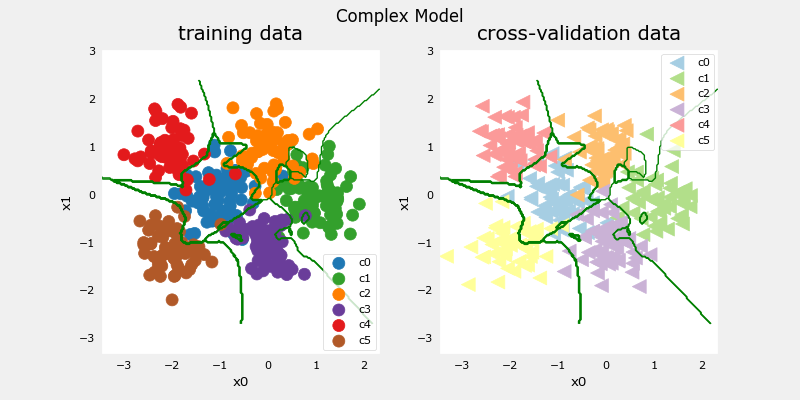

In [28]:
#make a model for plotting routines to call
model_predict = lambda Xl: np.argmax(tf.nn.softmax(model.predict(Xl)).numpy(),axis=1)
plt_nn(model_predict,X_train,y_train, classes, X_cv, y_cv, suptitle="Complex Model")

This model has worked very hard to capture outliers of each category. As a result, it has miscategorized some of the cross-validation data. Let's calculate the classification error.

In [29]:
training_cerr_complex = eval_cat_err(y_train, model_predict(X_train))
cv_cerr_complex = eval_cat_err(y_cv, model_predict(X_cv))
print(f"categorization error, training, complex model: {training_cerr_complex:0.3f}")
print(f"categorization error, cv,       complex model: {cv_cerr_complex:0.3f}")

10/10 [==============================] - 0s 664us/step
categorization error, training, complex model: 0.025
categorization error, cv,       complex model: 0.125


<a name="5.1"></a>
### 5.1 Simple model
Now, let's try a simple model

<a name="ex04"></a>
### Exercise 4

Below, compose a two-layer model:
* Dense layer with 6 units, relu activation
* Dense layer with 6 units and a linear activation. 
Compile using
* loss with `SparseCategoricalCrossentropy`, remember to use  `from_logits=True`
* Adam optimizer with learning rate of 0.01.

In [30]:
# UNQ_C4
# GRADED CELL: model_s

tf.random.set_seed(1234)
model_s = Sequential(
    [
        ### START CODE HERE ### 
        tf.keras.layers.Dense(6, activation="relu"),
        tf.keras.layers.Dense(6, activation="linear")
        ### END CODE HERE ### 
    ], name = "Simple"
)
model_s.compile(
    ### START CODE HERE ### 
    loss=SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    ### START CODE HERE ### 
)


In [31]:
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)

# BEGIN UNIT TEST
model_s.fit(
    X_train,y_train,
    epochs=1000
)
# END UNIT TEST

Epoch 1/1000
13/13 [==============================] - 0s 897us/step - loss: 1.7349
Epoch 2/1000
13/13 [==============================] - 0s 735us/step - loss: 1.4281
Epoch 3/1000
13/13 [==============================] - 0s 683us/step - loss: 1.2199
Epoch 4/1000
13/13 [==============================] - 0s 711us/step - loss: 1.0159
Epoch 5/1000
13/13 [==============================] - 0s 764us/step - loss: 0.8409
Epoch 6/1000
13/13 [==============================] - 0s 749us/step - loss: 0.6935
Epoch 7/1000
13/13 [==============================] - 0s 922us/step - loss: 0.5858
Epoch 8/1000
13/13 [==============================] - 0s 816us/step - loss: 0.5047
Epoch 9/1000
13/13 [==============================] - 0s 679us/step - loss: 0.4483
Epoch 10/1000
13/13 [==============================] - 0s 832us/step - loss: 0.4069
Epoch 11/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3772
Epoch 12/1000
13/13 [==============================] - 0s 808us/step - loss: 0.3589
Epo

13/13 [==============================] - 0s 784us/step - loss: 0.1781
Epoch 387/1000
13/13 [==============================] - 0s 801us/step - loss: 0.1771
Epoch 388/1000
13/13 [==============================] - 0s 804us/step - loss: 0.1809
Epoch 389/1000
13/13 [==============================] - 0s 795us/step - loss: 0.1807
Epoch 390/1000
13/13 [==============================] - 0s 793us/step - loss: 0.1792
Epoch 391/1000
13/13 [==============================] - 0s 792us/step - loss: 0.1767
Epoch 392/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1767
Epoch 393/1000
13/13 [==============================] - 0s 853us/step - loss: 0.1763
Epoch 394/1000
13/13 [==============================] - 0s 800us/step - loss: 0.1768
Epoch 395/1000
13/13 [==============================] - 0s 875us/step - loss: 0.1789
Epoch 396/1000
13/13 [==============================] - 0s 909us/step - loss: 0.1801
Epoch 397/1000
13/13 [==============================] - 0s 867us/step - loss: 0.18

13/13 [==============================] - 0s 787us/step - loss: 0.1745
Epoch 483/1000
13/13 [==============================] - 0s 794us/step - loss: 0.1763
Epoch 484/1000
13/13 [==============================] - 0s 791us/step - loss: 0.1767
Epoch 485/1000
13/13 [==============================] - 0s 789us/step - loss: 0.1780
Epoch 486/1000
13/13 [==============================] - 0s 794us/step - loss: 0.1739
Epoch 487/1000
13/13 [==============================] - 0s 791us/step - loss: 0.1781
Epoch 488/1000
13/13 [==============================] - 0s 796us/step - loss: 0.1755
Epoch 489/1000
13/13 [==============================] - 0s 803us/step - loss: 0.1766
Epoch 490/1000
13/13 [==============================] - 0s 783us/step - loss: 0.1783
Epoch 491/1000
13/13 [==============================] - 0s 809us/step - loss: 0.1769
Epoch 492/1000
13/13 [==============================] - 0s 807us/step - loss: 0.1752
Epoch 493/1000
13/13 [==============================] - 0s 816us/step - loss: 0.

13/13 [==============================] - 0s 914us/step - loss: 0.1741
Epoch 579/1000
13/13 [==============================] - 0s 893us/step - loss: 0.1732
Epoch 580/1000
13/13 [==============================] - 0s 908us/step - loss: 0.1725
Epoch 581/1000
13/13 [==============================] - 0s 915us/step - loss: 0.1731
Epoch 582/1000
13/13 [==============================] - 0s 898us/step - loss: 0.1709
Epoch 583/1000
13/13 [==============================] - 0s 916us/step - loss: 0.1727
Epoch 584/1000
13/13 [==============================] - 0s 880us/step - loss: 0.1742
Epoch 585/1000
13/13 [==============================] - 0s 882us/step - loss: 0.1721
Epoch 586/1000
13/13 [==============================] - 0s 833us/step - loss: 0.1730
Epoch 587/1000
13/13 [==============================] - 0s 824us/step - loss: 0.1728
Epoch 588/1000
13/13 [==============================] - 0s 818us/step - loss: 0.1718
Epoch 589/1000
13/13 [==============================] - 0s 798us/step - loss: 0.

13/13 [==============================] - 0s 844us/step - loss: 0.1740
Epoch 675/1000
13/13 [==============================] - 0s 843us/step - loss: 0.1699
Epoch 676/1000
13/13 [==============================] - 0s 824us/step - loss: 0.1712
Epoch 677/1000
13/13 [==============================] - 0s 840us/step - loss: 0.1711
Epoch 678/1000
13/13 [==============================] - 0s 813us/step - loss: 0.1718
Epoch 679/1000
13/13 [==============================] - 0s 828us/step - loss: 0.1795
Epoch 680/1000
13/13 [==============================] - 0s 824us/step - loss: 0.1709
Epoch 681/1000
13/13 [==============================] - 0s 829us/step - loss: 0.1703
Epoch 682/1000
13/13 [==============================] - 0s 833us/step - loss: 0.1717
Epoch 683/1000
13/13 [==============================] - 0s 819us/step - loss: 0.1758
Epoch 684/1000
13/13 [==============================] - 0s 824us/step - loss: 0.1699
Epoch 685/1000
13/13 [==============================] - 0s 840us/step - loss: 0.

13/13 [==============================] - 0s 792us/step - loss: 0.1693
Epoch 771/1000
13/13 [==============================] - 0s 814us/step - loss: 0.1708
Epoch 772/1000
13/13 [==============================] - 0s 842us/step - loss: 0.1693
Epoch 773/1000
13/13 [==============================] - 0s 854us/step - loss: 0.1697
Epoch 774/1000
13/13 [==============================] - 0s 818us/step - loss: 0.1712
Epoch 775/1000
13/13 [==============================] - 0s 818us/step - loss: 0.1704
Epoch 776/1000
13/13 [==============================] - 0s 849us/step - loss: 0.1681
Epoch 777/1000
13/13 [==============================] - 0s 849us/step - loss: 0.1704
Epoch 778/1000
13/13 [==============================] - 0s 828us/step - loss: 0.1721
Epoch 779/1000
13/13 [==============================] - 0s 846us/step - loss: 0.1706
Epoch 780/1000
13/13 [==============================] - 0s 845us/step - loss: 0.1747
Epoch 781/1000
13/13 [==============================] - 0s 850us/step - loss: 0.

13/13 [==============================] - 0s 860us/step - loss: 0.1702
Epoch 867/1000
13/13 [==============================] - 0s 873us/step - loss: 0.1695
Epoch 868/1000
13/13 [==============================] - 0s 893us/step - loss: 0.1728
Epoch 869/1000
13/13 [==============================] - 0s 892us/step - loss: 0.1682
Epoch 870/1000
13/13 [==============================] - 0s 864us/step - loss: 0.1681
Epoch 871/1000
13/13 [==============================] - 0s 857us/step - loss: 0.1684
Epoch 872/1000
13/13 [==============================] - 0s 831us/step - loss: 0.1680
Epoch 873/1000
13/13 [==============================] - 0s 811us/step - loss: 0.1720
Epoch 874/1000
13/13 [==============================] - 0s 820us/step - loss: 0.1705
Epoch 875/1000
13/13 [==============================] - 0s 824us/step - loss: 0.1686
Epoch 876/1000
13/13 [==============================] - 0s 857us/step - loss: 0.1676
Epoch 877/1000
13/13 [==============================] - 0s 814us/step - loss: 0.

13/13 [==============================] - 0s 1ms/step - loss: 0.1667
Epoch 963/1000
13/13 [==============================] - 0s 854us/step - loss: 0.1757
Epoch 964/1000
13/13 [==============================] - 0s 871us/step - loss: 0.1661
Epoch 965/1000
13/13 [==============================] - 0s 859us/step - loss: 0.1713
Epoch 966/1000
13/13 [==============================] - 0s 847us/step - loss: 0.1671
Epoch 967/1000
13/13 [==============================] - 0s 831us/step - loss: 0.1697
Epoch 968/1000
13/13 [==============================] - 0s 816us/step - loss: 0.1716
Epoch 969/1000
13/13 [==============================] - 0s 882us/step - loss: 0.1688
Epoch 970/1000
13/13 [==============================] - 0s 941us/step - loss: 0.1672
Epoch 971/1000
13/13 [==============================] - 0s 887us/step - loss: 0.1664
Epoch 972/1000
13/13 [==============================] - 0s 879us/step - loss: 0.1684
Epoch 973/1000
13/13 [==============================] - 0s 857us/step - loss: 0.16

In [32]:
# BEGIN UNIT TEST
model_s.summary()

model_s_test(model_s, classes, X_train.shape[1])
# END UNIT TEST

Model: "Simple"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 6)                 18        
                                                                 
 dense_7 (Dense)             (None, 6)                 42        
                                                                 
Total params: 60 (480.00 Byte)
Trainable params: 60 (480.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
All tests passed!


<details>
  <summary><font size="3" color="darkgreen"><b>Click for hints</b></font></summary>
    
Summary should match this (layer instance names may increment )
```
Model: "Simple"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
L1 (Dense)                   (None, 6)                 18        
_________________________________________________________________
L2 (Dense)                   (None, 6)                 42        
=================================================================
Total params: 60
Trainable params: 60
Non-trainable params: 0
_________________________________________________________________
```
  <details>
  <summary><font size="3" color="darkgreen"><b>Click for more hints</b></font></summary>
  
```python
tf.random.set_seed(1234)
model_s = Sequential(
    [
        Dense(6, activation = 'relu', name="L1"),            # @REPLACE
        Dense(classes, activation = 'linear', name="L2")     # @REPLACE
    ], name = "Simple"
)
model_s.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),     # @REPLACE
    optimizer=tf.keras.optimizers.Adam(0.01),     # @REPLACE
)

model_s.fit(
    X_train,y_train,
    epochs=1000
)                                   
``` 

1082/1082 [==============================] - 0s 438us/step


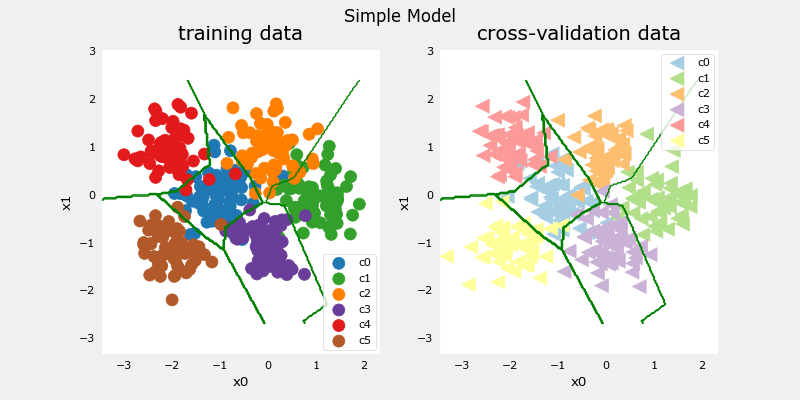

In [33]:
#make a model for plotting routines to call
model_predict_s = lambda Xl: np.argmax(tf.nn.softmax(model_s.predict(Xl)).numpy(),axis=1)
plt_nn(model_predict_s,X_train,y_train, classes, X_cv, y_cv, suptitle="Simple Model")

This simple models does pretty well. Let's calculate the classification error.

In [34]:
training_cerr_simple = eval_cat_err(y_train, model_predict_s(X_train))
cv_cerr_simple = eval_cat_err(y_cv, model_predict_s(X_cv))
print(f"categorization error, training, simple model, {training_cerr_simple:0.3f}, complex model: {training_cerr_complex:0.3f}" )
print(f"categorization error, cv,       simple model, {cv_cerr_simple:0.3f}, complex model: {cv_cerr_complex:0.3f}" )

10/10 [==============================] - 0s 596us/step
categorization error, training, simple model, 0.068, complex model: 0.025
categorization error, cv,       simple model, 0.075, complex model: 0.125


Our simple model has a little higher classification error on training data but does better on cross-validation data than the more complex model.

<a name="6"></a>
## 6 - Regularization
As in the case of polynomial regression, one can apply regularization to moderate the impact of a more complex model. Let's try this below.

<a name="ex05"></a>
### Exercise 5

Reconstruct your complex model, but this time include regularization.
Below, compose a three-layer model:
* Dense layer with 120 units, relu activation, `kernel_regularizer=tf.keras.regularizers.l2(0.1)`
* Dense layer with 40 units, relu activation, `kernel_regularizer=tf.keras.regularizers.l2(0.1)`
* Dense layer with 6 units and a linear activation. 
Compile using
* loss with `SparseCategoricalCrossentropy`, remember to use  `from_logits=True`
* Adam optimizer with learning rate of 0.01.

In [35]:
# UNQ_C5
# GRADED CELL: model_r

tf.random.set_seed(1234)
model_r = Sequential(
    [
        ### START CODE HERE ### 
        tf.keras.layers.Dense(120, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.1)),
        tf.keras.layers.Dense(40, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.1)),
        tf.keras.layers.Dense(6, activation="linear")
        ### START CODE HERE ### 
    ], name= None
)
model_r.compile(
    ### START CODE HERE ### 
    loss=SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    ### START CODE HERE ### 
)


In [40]:
# BEGIN UNIT TEST
model_r.fit(
    X_train, y_train,
    epochs=1000
)
# END UNIT TEST

Epoch 1/1000
13/13 [==============================] - 0s 974us/step - loss: 0.3619
Epoch 2/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3488
Epoch 3/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3452
Epoch 4/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3323
Epoch 5/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3158
Epoch 6/1000
13/13 [==============================] - 0s 833us/step - loss: 0.3277
Epoch 7/1000
13/13 [==============================] - 0s 779us/step - loss: 0.3623
Epoch 8/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3226
Epoch 9/1000
13/13 [==============================] - 0s 921us/step - loss: 0.3184
Epoch 10/1000
13/13 [==============================] - 0s 964us/step - loss: 0.3115
Epoch 11/1000
13/13 [==============================] - 0s 954us/step - loss: 0.3307
Epoch 12/1000
13/13 [==============================] - 0s 950us/step - loss: 0.3259
Epoch 13/10

13/13 [==============================] - 0s 3ms/step - loss: 0.3489
Epoch 592/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3452
Epoch 593/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3429
Epoch 594/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3425
Epoch 595/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4209
Epoch 596/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3978
Epoch 597/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3565
Epoch 598/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3443
Epoch 599/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3419
Epoch 600/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3529
Epoch 601/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3345
Epoch 602/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3436
Epoch 603/1000
13/1

13/13 [==============================] - 0s 1ms/step - loss: 0.3976
Epoch 690/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3724
Epoch 691/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3471
Epoch 692/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3554
Epoch 693/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3445
Epoch 694/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3483
Epoch 695/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3390
Epoch 696/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3378
Epoch 697/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3355
Epoch 698/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3517
Epoch 699/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3456
Epoch 700/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3493
Epoch 701/1000
13/1

13/13 [==============================] - 0s 1ms/step - loss: 0.3368
Epoch 788/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3307
Epoch 789/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3382
Epoch 790/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3355
Epoch 791/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3734
Epoch 792/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3761
Epoch 793/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3444
Epoch 794/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3632
Epoch 795/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3406
Epoch 796/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3788
Epoch 797/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3315
Epoch 798/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3506
Epoch 799/1000
13/1

13/13 [==============================] - 0s 1ms/step - loss: 0.3704
Epoch 886/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3419
Epoch 887/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3491
Epoch 888/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3509
Epoch 889/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3373
Epoch 890/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3713
Epoch 891/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3285
Epoch 892/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3294
Epoch 893/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3340
Epoch 894/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3266
Epoch 895/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3464
Epoch 896/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3392
Epoch 897/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.3174
Epoch 984/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3339
Epoch 985/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3361
Epoch 986/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3253
Epoch 987/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3248
Epoch 988/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3199
Epoch 989/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3323
Epoch 990/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3463
Epoch 991/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3422
Epoch 992/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3354
Epoch 993/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3225
Epoch 994/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3282
Epoch 995/1000
13/1

In [41]:
# BEGIN UNIT TEST
model_r.summary()

model_r_test(model_r, classes, X_train.shape[1]) 
# END UNIT TEST

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 120)               360       
                                                                 
 dense_9 (Dense)             (None, 40)                4840      
                                                                 
 dense_10 (Dense)            (None, 6)                 246       
                                                                 
Total params: 5446 (42.55 KB)
Trainable params: 5446 (42.55 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
ddd
All tests passed!


<details>
  <summary><font size="3" color="darkgreen"><b>Click for hints</b></font></summary>
    
Summary should match this (layer instance names may increment )
```
Model: "ComplexRegularized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
L1 (Dense)                   (None, 120)               360       
_________________________________________________________________
L2 (Dense)                   (None, 40)                4840      
_________________________________________________________________
L3 (Dense)                   (None, 6)                 246       
=================================================================
Total params: 5,446
Trainable params: 5,446
Non-trainable params: 0
_________________________________________________________________
```
  <details>
  <summary><font size="3" color="darkgreen"><b>Click for more hints</b></font></summary>
  
```python
tf.random.set_seed(1234)
model_r = Sequential(
    [
        Dense(120, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(0.1), name="L1"), 
        Dense(40, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(0.1), name="L2"),  
        Dense(classes, activation = 'linear', name="L3")  
    ], name="ComplexRegularized"
)
model_r.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
    optimizer=tf.keras.optimizers.Adam(0.01),                             
)

model_r.fit(
    X_train,y_train,
    epochs=1000
)                                   
``` 

1082/1082 [==============================] - 1s 472us/step


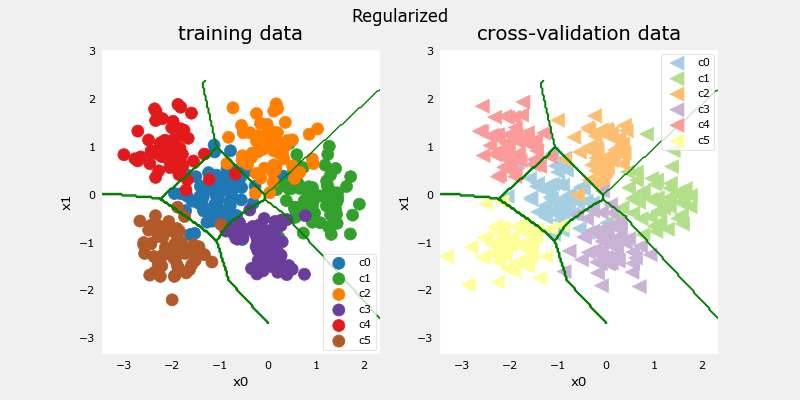

In [42]:
#make a model for plotting routines to call
model_predict_r = lambda Xl: np.argmax(tf.nn.softmax(model_r.predict(Xl)).numpy(),axis=1)
 
plt_nn(model_predict_r, X_train,y_train, classes, X_cv, y_cv, suptitle="Regularized")

The results look very similar to the 'ideal' model. Let's check classification error.

In [43]:
training_cerr_reg = eval_cat_err(y_train, model_predict_r(X_train))
cv_cerr_reg = eval_cat_err(y_cv, model_predict_r(X_cv))
test_cerr_reg = eval_cat_err(y_test, model_predict_r(X_test))
print(f"categorization error, training, regularized: {training_cerr_reg:0.3f}, simple model, {training_cerr_simple:0.3f}, complex model: {training_cerr_complex:0.3f}" )
print(f"categorization error, cv,       regularized: {cv_cerr_reg:0.3f}, simple model, {cv_cerr_simple:0.3f}, complex model: {cv_cerr_complex:0.3f}" )

3/3 [==============================] - 0s 898us/step
categorization error, training, regularized: 0.068, simple model, 0.068, complex model: 0.025
categorization error, cv,       regularized: 0.066, simple model, 0.075, complex model: 0.125


The simple model is a bit better in the training set than the regularized model but it worse in the cross validation set.

<a name="7"></a>
## 7 - Iterate to find optimal regularization value
As you did in linear regression, you can try many regularization values. This code takes several minutes to run. If you have time, you can run it and check the results. If not, you have completed the graded parts of the assignment!

In [ ]:
tf.random.set_seed(1234)
lambdas = [0.0, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3]
models=[None] * len(lambdas)
for i in range(len(lambdas)):
    lambda_ = lambdas[i]
    models[i] =  Sequential(
        [
            Dense(120, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(lambda_)),
            Dense(40, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(lambda_)),
            Dense(classes, activation = 'linear')
        ]
    )
    models[i].compile(
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        optimizer=tf.keras.optimizers.Adam(0.01),
    )

    models[i].fit(
        X_train,y_train,
        epochs=1000
    )
    print(f"Finished lambda = {lambda_}")


Epoch 1/1000
13/13 [==============================] - 0s 989us/step - loss: 1.0786
Epoch 2/1000
13/13 [==============================] - 0s 822us/step - loss: 0.4086
Epoch 3/1000
13/13 [==============================] - 0s 826us/step - loss: 0.3117
Epoch 4/1000
13/13 [==============================] - 0s 904us/step - loss: 0.2687
Epoch 5/1000
13/13 [==============================] - 0s 867us/step - loss: 0.2665
Epoch 6/1000
13/13 [==============================] - 0s 848us/step - loss: 0.2827
Epoch 7/1000
13/13 [==============================] - 0s 856us/step - loss: 0.2365
Epoch 8/1000
13/13 [==============================] - 0s 842us/step - loss: 0.2282
Epoch 9/1000
13/13 [==============================] - 0s 865us/step - loss: 0.2310
Epoch 10/1000
13/13 [==============================] - 0s 753us/step - loss: 0.1973
Epoch 11/1000
13/13 [==============================] - 0s 789us/step - loss: 0.2174
Epoch 12/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2063
Epo

13/13 [==============================] - 0s 1ms/step - loss: 0.1423
Epoch 200/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1381
Epoch 201/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1105
Epoch 202/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1005
Epoch 203/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0846
Epoch 204/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1125
Epoch 205/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1129
Epoch 206/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1219
Epoch 207/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1161
Epoch 208/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1137
Epoch 209/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1178
Epoch 210/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1017
Epoch 211/1000
13/1

13/13 [==============================] - 0s 1ms/step - loss: 0.0800
Epoch 298/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0803
Epoch 299/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0765
Epoch 300/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0733
Epoch 301/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0544
Epoch 302/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0718
Epoch 303/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0877
Epoch 304/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0687
Epoch 305/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0671
Epoch 306/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0575
Epoch 307/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0773
Epoch 308/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0779
Epoch 309/1000
13/1

13/13 [==============================] - 0s 1ms/step - loss: 0.0844
Epoch 396/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0704
Epoch 397/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0700
Epoch 398/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0591
Epoch 399/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0586
Epoch 400/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0628
Epoch 401/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1717
Epoch 402/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1648
Epoch 403/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1616
Epoch 404/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1326
Epoch 405/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1367
Epoch 406/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1098
Epoch 407/1000
13/1

13/13 [==============================] - 0s 1ms/step - loss: 0.0484
Epoch 494/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0639
Epoch 495/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0497
Epoch 496/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0787
Epoch 497/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0805
Epoch 498/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0639
Epoch 499/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0504
Epoch 500/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0478
Epoch 501/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0466
Epoch 502/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0419
Epoch 503/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0365
Epoch 504/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0352
Epoch 505/1000
13/1

13/13 [==============================] - 0s 1ms/step - loss: 0.0305
Epoch 592/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0278
Epoch 593/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0343
Epoch 594/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0259
Epoch 595/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0259
Epoch 596/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0258
Epoch 597/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0262
Epoch 598/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0254
Epoch 599/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0251
Epoch 600/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0241
Epoch 601/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0269
Epoch 602/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0287
Epoch 603/1000
13/1

13/13 [==============================] - 0s 1ms/step - loss: 0.1437
Epoch 690/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0897
Epoch 691/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0665
Epoch 692/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0579
Epoch 693/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0563
Epoch 694/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0425
Epoch 695/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0441
Epoch 696/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0411
Epoch 697/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0429
Epoch 698/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0347
Epoch 699/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0367
Epoch 700/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0311
Epoch 701/1000
13/1

13/13 [==============================] - 0s 1ms/step - loss: 0.0360
Epoch 788/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0324
Epoch 789/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0329
Epoch 790/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0291
Epoch 791/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0283
Epoch 792/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0291
Epoch 793/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0261
Epoch 794/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0294
Epoch 795/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0250
Epoch 796/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0292
Epoch 797/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0286
Epoch 798/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0271
Epoch 799/1000
13/1

13/13 [==============================] - 0s 1ms/step - loss: 0.0291
Epoch 886/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0309
Epoch 887/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0289
Epoch 888/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0294
Epoch 889/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0283
Epoch 890/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0240
Epoch 891/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0232
Epoch 892/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0225
Epoch 893/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0196
Epoch 894/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0218
Epoch 895/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0189
Epoch 896/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0221
Epoch 897/1000
13/1

13/13 [==============================] - 0s 1ms/step - loss: 0.0328
Epoch 984/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0276
Epoch 985/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0227
Epoch 986/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0235
Epoch 987/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0287
Epoch 988/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0170
Epoch 989/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0166
Epoch 990/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0175
Epoch 991/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0149
Epoch 992/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0152
Epoch 993/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.0153
Epoch 994/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.0142
Epoch 995/1000
13/1

13/13 [==============================] - 0s 1ms/step - loss: 0.2478
Epoch 83/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2346
Epoch 84/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2324
Epoch 85/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2536
Epoch 86/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2255
Epoch 87/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2297
Epoch 88/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2306
Epoch 89/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2300
Epoch 90/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2262
Epoch 91/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2189
Epoch 92/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2184
Epoch 93/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2201
Epoch 94/1000
13/13 [=========

13/13 [==============================] - 0s 1ms/step - loss: 0.2208
Epoch 182/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2110
Epoch 183/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2122
Epoch 184/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2098
Epoch 185/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2084
Epoch 186/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1989
Epoch 187/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2045
Epoch 188/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2013
Epoch 189/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2033
Epoch 190/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2129
Epoch 191/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2110
Epoch 192/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2040
Epoch 193/1000
13/1

13/13 [==============================] - 0s 1ms/step - loss: 0.2000
Epoch 280/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1983
Epoch 281/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1969
Epoch 282/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1901
Epoch 283/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1988
Epoch 284/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1857
Epoch 285/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1860
Epoch 286/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1946
Epoch 287/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1907
Epoch 288/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2126
Epoch 289/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2023
Epoch 290/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1985
Epoch 291/1000
13/1

13/13 [==============================] - 0s 1ms/step - loss: 0.1793
Epoch 378/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1850
Epoch 379/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1849
Epoch 380/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1833
Epoch 381/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1820
Epoch 382/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1913
Epoch 383/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2015
Epoch 384/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1958
Epoch 385/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1810
Epoch 386/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1816
Epoch 387/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1793
Epoch 388/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1775
Epoch 389/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.1811
Epoch 476/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1756
Epoch 477/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1820
Epoch 478/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1972
Epoch 479/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1826
Epoch 480/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1786
Epoch 481/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1727
Epoch 482/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1761
Epoch 483/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1784
Epoch 484/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1865
Epoch 485/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1801
Epoch 486/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1695
Epoch 487/1000
13/1

13/13 [==============================] - 0s 1ms/step - loss: 0.1668
Epoch 574/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1646
Epoch 575/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1633
Epoch 576/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1623
Epoch 577/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1674
Epoch 578/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1770
Epoch 579/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1626
Epoch 580/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1734
Epoch 581/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1641
Epoch 582/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1642
Epoch 583/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1660
Epoch 584/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1715
Epoch 585/1000
13/1

13/13 [==============================] - 0s 1ms/step - loss: 0.1640
Epoch 672/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1693
Epoch 673/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1591
Epoch 674/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1650
Epoch 675/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1610
Epoch 676/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1566
Epoch 677/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1623
Epoch 678/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1564
Epoch 679/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1675
Epoch 680/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1742
Epoch 681/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1790
Epoch 682/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1779
Epoch 683/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.1516
Epoch 770/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1537
Epoch 771/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1596
Epoch 772/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1531
Epoch 773/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1655
Epoch 774/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1720
Epoch 775/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1744
Epoch 776/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1563
Epoch 777/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1590
Epoch 778/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1543
Epoch 779/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1536
Epoch 780/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1526
Epoch 781/1000
13/1

13/13 [==============================] - 0s 1ms/step - loss: 0.1567
Epoch 868/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1579
Epoch 869/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1508
Epoch 870/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1573
Epoch 871/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1512
Epoch 872/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1483
Epoch 873/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1507
Epoch 874/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1528
Epoch 875/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1563
Epoch 876/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1574
Epoch 877/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1532
Epoch 878/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1611
Epoch 879/1000
13/1

13/13 [==============================] - 0s 1ms/step - loss: 0.1506
Epoch 966/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1461
Epoch 967/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1539
Epoch 968/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1624
Epoch 969/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1565
Epoch 970/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1548
Epoch 971/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1566
Epoch 972/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1498
Epoch 973/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.1529
Epoch 974/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.1591
Epoch 975/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1545
Epoch 976/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.1460
Epoch 977/1000
13/1

13/13 [==============================] - 0s 1ms/step - loss: 0.3533
Epoch 65/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3558
Epoch 66/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3334
Epoch 67/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3456
Epoch 68/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3420
Epoch 69/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3175
Epoch 70/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3176
Epoch 71/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3266
Epoch 72/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2945
Epoch 73/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3038
Epoch 74/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3079
Epoch 75/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3156
Epoch 76/1000
13/13 [=========

13/13 [==============================] - 0s 3ms/step - loss: 0.2780
Epoch 164/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2863
Epoch 165/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2836
Epoch 166/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2751
Epoch 167/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2735
Epoch 168/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2831
Epoch 169/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2756
Epoch 170/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2754
Epoch 171/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2655
Epoch 172/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2590
Epoch 173/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2792
Epoch 174/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2796
Epoch 175/1000
13/1

13/13 [==============================] - 0s 1ms/step - loss: 0.2679
Epoch 262/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2653
Epoch 263/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2528
Epoch 264/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2496
Epoch 265/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2681
Epoch 266/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2748
Epoch 267/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2691
Epoch 268/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2595
Epoch 269/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2501
Epoch 270/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2638
Epoch 271/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2488
Epoch 272/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2590
Epoch 273/1000
13/1

13/13 [==============================] - 0s 1ms/step - loss: 0.2456
Epoch 360/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2712
Epoch 361/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2578
Epoch 362/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2887
Epoch 363/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2854
Epoch 364/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2674
Epoch 365/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2514
Epoch 366/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2513
Epoch 367/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2746
Epoch 368/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2747
Epoch 369/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2498
Epoch 370/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2489
Epoch 371/1000
13/1

13/13 [==============================] - 0s 1ms/step - loss: 0.2328
Epoch 458/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2508
Epoch 459/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2407
Epoch 460/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2385
Epoch 461/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2616
Epoch 462/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2420
Epoch 463/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2382
Epoch 464/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2448
Epoch 465/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2504
Epoch 466/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2577
Epoch 467/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2492
Epoch 468/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2464
Epoch 469/1000
13/1

13/13 [==============================] - 0s 1ms/step - loss: 0.2409
Epoch 556/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2248
Epoch 557/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2315
Epoch 558/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2424
Epoch 559/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2582
Epoch 560/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2552
Epoch 561/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2392
Epoch 562/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2518
Epoch 563/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2296
Epoch 564/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2423
Epoch 565/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2346
Epoch 566/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2342
Epoch 567/1000
13/1

13/13 [==============================] - 0s 1ms/step - loss: 0.2212
Epoch 654/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2405
Epoch 655/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2316
Epoch 656/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2244
Epoch 657/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2280
Epoch 658/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2265
Epoch 659/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2217
Epoch 660/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2351
Epoch 661/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2234
Epoch 662/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2297
Epoch 663/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2287
Epoch 664/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2537
Epoch 665/1000
13/1

13/13 [==============================] - 0s 1ms/step - loss: 0.2275
Epoch 752/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2332
Epoch 753/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2187
Epoch 754/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2307
Epoch 755/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2266
Epoch 756/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2251
Epoch 757/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2315
Epoch 758/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2266
Epoch 759/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2236
Epoch 760/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2401
Epoch 761/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2431
Epoch 762/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2319
Epoch 763/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.2212
Epoch 850/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2196
Epoch 851/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2211
Epoch 852/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2321
Epoch 853/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2166
Epoch 854/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2278
Epoch 855/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2295
Epoch 856/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2205
Epoch 857/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2324
Epoch 858/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2211
Epoch 859/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2291
Epoch 860/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2217
Epoch 861/1000
13/1

13/13 [==============================] - 0s 1ms/step - loss: 0.2318
Epoch 948/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2295
Epoch 949/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2165
Epoch 950/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2121
Epoch 951/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2133
Epoch 952/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2369
Epoch 953/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2243
Epoch 954/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2267
Epoch 955/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2148
Epoch 956/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2183
Epoch 957/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2261
Epoch 958/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2436
Epoch 959/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.4719
Epoch 47/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4354
Epoch 48/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4829
Epoch 49/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4672
Epoch 50/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4401
Epoch 51/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4549
Epoch 52/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4391
Epoch 53/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4545
Epoch 54/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4341
Epoch 55/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4627
Epoch 56/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4228
Epoch 57/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4406
Epoch 58/1000
13/13 [=========

13/13 [==============================] - 0s 1ms/step - loss: 0.3635
Epoch 146/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3615
Epoch 147/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3911
Epoch 148/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3709
Epoch 149/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3614
Epoch 150/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3586
Epoch 151/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3585
Epoch 152/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3561
Epoch 153/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3813
Epoch 154/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3619
Epoch 155/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3649
Epoch 156/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3631
Epoch 157/1000
13/1

13/13 [==============================] - 0s 1ms/step - loss: 0.3369
Epoch 244/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3468
Epoch 245/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3472
Epoch 246/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3458
Epoch 247/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3313
Epoch 248/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3407
Epoch 249/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3521
Epoch 250/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3412
Epoch 251/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3704
Epoch 252/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3543
Epoch 253/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3425
Epoch 254/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3580
Epoch 255/1000
13/1

13/13 [==============================] - 0s 1ms/step - loss: 0.3273
Epoch 342/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3430
Epoch 343/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3294
Epoch 344/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3224
Epoch 345/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3210
Epoch 346/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3267
Epoch 347/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3359
Epoch 348/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3467
Epoch 349/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3143
Epoch 350/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3377
Epoch 351/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3183
Epoch 352/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3420
Epoch 353/1000
13/1

13/13 [==============================] - 0s 1ms/step - loss: 0.3055
Epoch 440/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3063
Epoch 441/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3159
Epoch 442/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3270
Epoch 443/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3191
Epoch 444/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3133
Epoch 445/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3239
Epoch 446/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3118
Epoch 447/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3383
Epoch 448/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3302
Epoch 449/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3083
Epoch 450/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3117
Epoch 451/1000
13/1

13/13 [==============================] - 0s 1ms/step - loss: 0.3586
Epoch 538/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3209
Epoch 539/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2946
Epoch 540/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3151
Epoch 541/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3265
Epoch 542/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3297
Epoch 543/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3176
Epoch 544/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3109
Epoch 545/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3033
Epoch 546/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3208
Epoch 547/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3347
Epoch 548/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3134
Epoch 549/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.3340
Epoch 636/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3206
Epoch 637/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3102
Epoch 638/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3004
Epoch 639/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2979
Epoch 640/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2924
Epoch 641/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2917
Epoch 642/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3073
Epoch 643/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3169
Epoch 644/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2949
Epoch 645/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3102
Epoch 646/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3222
Epoch 647/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.3022
Epoch 734/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3208
Epoch 735/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3123
Epoch 736/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3176
Epoch 737/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3273
Epoch 738/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3049
Epoch 739/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3050
Epoch 740/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3130
Epoch 741/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3245
Epoch 742/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3511
Epoch 743/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2981
Epoch 744/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2957
Epoch 745/1000
13/1

13/13 [==============================] - 0s 1ms/step - loss: 0.3185
Epoch 832/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3020
Epoch 833/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2999
Epoch 834/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.2981
Epoch 835/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2876
Epoch 836/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2885
Epoch 837/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2931
Epoch 838/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3015
Epoch 839/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2924
Epoch 840/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3144
Epoch 841/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2857
Epoch 842/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3091
Epoch 843/1000
13/1

13/13 [==============================] - 0s 1ms/step - loss: 0.3047
Epoch 930/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3171
Epoch 931/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3025
Epoch 932/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2939
Epoch 933/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2956
Epoch 934/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3315
Epoch 935/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2986
Epoch 936/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2862
Epoch 937/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2846
Epoch 938/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3029
Epoch 939/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.2871
Epoch 940/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.2850
Epoch 941/1000
13/1

13/13 [==============================] - 0s 1ms/step - loss: 0.6171
Epoch 29/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.6046
Epoch 30/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.6245
Epoch 31/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.6138
Epoch 32/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.6378
Epoch 33/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.6188
Epoch 34/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.6609
Epoch 35/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.6587
Epoch 36/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.6282
Epoch 37/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.5878
Epoch 38/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.5705
Epoch 39/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.5768
Epoch 40/1000
13/13 [=========

13/13 [==============================] - 0s 1ms/step - loss: 0.4486
Epoch 128/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4340
Epoch 129/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4457
Epoch 130/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4411
Epoch 131/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4718
Epoch 132/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4376
Epoch 133/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4273
Epoch 134/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4512
Epoch 135/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4458
Epoch 136/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4567
Epoch 137/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4315
Epoch 138/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4510
Epoch 139/1000
13/1

13/13 [==============================] - 0s 1ms/step - loss: 0.4357
Epoch 226/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4371
Epoch 227/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4695
Epoch 228/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4047
Epoch 229/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4031
Epoch 230/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4150
Epoch 231/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4023
Epoch 232/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4166
Epoch 233/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3921
Epoch 234/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3898
Epoch 235/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3890
Epoch 236/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3963
Epoch 237/1000
13/1

13/13 [==============================] - 0s 1ms/step - loss: 0.4095
Epoch 324/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4046
Epoch 325/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3951
Epoch 326/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3824
Epoch 327/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3739
Epoch 328/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3923
Epoch 329/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3759
Epoch 330/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3641
Epoch 331/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3680
Epoch 332/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3700
Epoch 333/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4051
Epoch 334/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3900
Epoch 335/1000
13/1

13/13 [==============================] - 0s 1ms/step - loss: 0.3819
Epoch 422/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3949
Epoch 423/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3729
Epoch 424/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3723
Epoch 425/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3629
Epoch 426/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3592
Epoch 427/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3591
Epoch 428/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3646
Epoch 429/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3617
Epoch 430/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3552
Epoch 431/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3467
Epoch 432/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3546
Epoch 433/1000
13/1

13/13 [==============================] - 0s 1ms/step - loss: 0.3615
Epoch 520/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3602
Epoch 521/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3425
Epoch 522/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3611
Epoch 523/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3701
Epoch 524/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3372
Epoch 525/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3461
Epoch 526/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3518
Epoch 527/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3366
Epoch 528/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3418
Epoch 529/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3717
Epoch 530/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3589
Epoch 531/1000
13/1

13/13 [==============================] - 0s 1ms/step - loss: 0.3234
Epoch 618/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3666
Epoch 619/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3905
Epoch 620/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3792
Epoch 621/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3499
Epoch 622/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3506
Epoch 623/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3339
Epoch 624/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3266
Epoch 625/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3235
Epoch 626/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3377
Epoch 627/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3526
Epoch 628/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3644
Epoch 629/1000
13/1

13/13 [==============================] - 0s 1ms/step - loss: 0.3257
Epoch 716/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3310
Epoch 717/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3459
Epoch 718/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3696
Epoch 719/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4027
Epoch 720/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3473
Epoch 721/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3392
Epoch 722/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3264
Epoch 723/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3577
Epoch 724/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3511
Epoch 725/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3742
Epoch 726/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3558
Epoch 727/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.3243
Epoch 814/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3294
Epoch 815/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3447
Epoch 816/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3470
Epoch 817/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3561
Epoch 818/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3352
Epoch 819/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3211
Epoch 820/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3581
Epoch 821/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3856
Epoch 822/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3392
Epoch 823/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3413
Epoch 824/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3403
Epoch 825/1000
13/1

13/13 [==============================] - 0s 1ms/step - loss: 0.3209
Epoch 912/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3239
Epoch 913/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3153
Epoch 914/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3464
Epoch 915/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3383
Epoch 916/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3459
Epoch 917/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3375
Epoch 918/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3303
Epoch 919/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3524
Epoch 920/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3599
Epoch 921/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3388
Epoch 922/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3469
Epoch 923/1000
13/1

13/13 [==============================] - 0s 1ms/step - loss: 1.0284
Epoch 10/1000
13/13 [==============================] - 0s 1ms/step - loss: 1.0016
Epoch 11/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.9683
Epoch 12/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.9504
Epoch 13/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.9524
Epoch 14/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.9500
Epoch 15/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.9075
Epoch 16/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.8961
Epoch 17/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.8946
Epoch 18/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.8974
Epoch 19/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.8728
Epoch 20/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.8463
Epoch 21/1000
13/13 [=========

Epoch 109/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.5614
Epoch 110/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.5551
Epoch 111/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.5539
Epoch 112/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.5501
Epoch 113/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.5429
Epoch 114/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.5430
Epoch 115/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.5422
Epoch 116/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.5442
Epoch 117/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.5777
Epoch 118/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.5710
Epoch 119/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.5637
Epoch 120/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.5547
Epoc

13/13 [==============================] - 0s 1ms/step - loss: 0.5041
Epoch 208/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.5060
Epoch 209/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.5147
Epoch 210/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4868
Epoch 211/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4933
Epoch 212/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4781
Epoch 213/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4768
Epoch 214/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4778
Epoch 215/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4822
Epoch 216/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4962
Epoch 217/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4872
Epoch 218/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4994
Epoch 219/1000
13/1

13/13 [==============================] - 0s 1ms/step - loss: 0.4483
Epoch 306/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4747
Epoch 307/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4580
Epoch 308/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4517
Epoch 309/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4528
Epoch 310/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4420
Epoch 311/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4358
Epoch 312/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4391
Epoch 313/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4479
Epoch 314/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4500
Epoch 315/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4424
Epoch 316/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4400
Epoch 317/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.4301
Epoch 404/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4372
Epoch 405/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4209
Epoch 406/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4182
Epoch 407/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4315
Epoch 408/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4433
Epoch 409/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4187
Epoch 410/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4314
Epoch 411/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4556
Epoch 412/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4186
Epoch 413/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4261
Epoch 414/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4419
Epoch 415/1000
13/1

13/13 [==============================] - 0s 1ms/step - loss: 0.4050
Epoch 502/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4194
Epoch 503/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4447
Epoch 504/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4713
Epoch 505/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4511
Epoch 506/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4484
Epoch 507/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4303
Epoch 508/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4030
Epoch 509/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4085
Epoch 510/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4034
Epoch 511/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4171
Epoch 512/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4094
Epoch 513/1000
13/1

13/13 [==============================] - 0s 1ms/step - loss: 0.3899
Epoch 600/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4048
Epoch 601/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3811
Epoch 602/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3963
Epoch 603/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3960
Epoch 604/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4078
Epoch 605/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4062
Epoch 606/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4323
Epoch 607/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4111
Epoch 608/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4204
Epoch 609/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4018
Epoch 610/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4288
Epoch 611/1000
13/1

13/13 [==============================] - 0s 1ms/step - loss: 0.3900
Epoch 698/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4123
Epoch 699/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3941
Epoch 700/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3848
Epoch 701/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3979
Epoch 702/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3843
Epoch 703/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3733
Epoch 704/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4032
Epoch 705/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3955
Epoch 706/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3935
Epoch 707/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4077
Epoch 708/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4006
Epoch 709/1000
13/1

13/13 [==============================] - 0s 1ms/step - loss: 0.3819
Epoch 796/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4294
Epoch 797/1000
13/13 [==============================] - 0s 5ms/step - loss: 0.3900
Epoch 798/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4082
Epoch 799/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3857
Epoch 800/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3871
Epoch 801/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3892
Epoch 802/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3772
Epoch 803/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3703
Epoch 804/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3647
Epoch 805/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3843
Epoch 806/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3837
Epoch 807/1000
13/1

13/13 [==============================] - 0s 1ms/step - loss: 0.3984
Epoch 894/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3896
Epoch 895/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4349
Epoch 896/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4009
Epoch 897/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3860
Epoch 898/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4113
Epoch 899/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4130
Epoch 900/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3933
Epoch 901/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4191
Epoch 902/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4013
Epoch 903/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3950
Epoch 904/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3678
Epoch 905/1000
13/1

13/13 [==============================] - 0s 1ms/step - loss: 0.3784
Epoch 992/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3695
Epoch 993/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3768
Epoch 994/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3748
Epoch 995/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3912
Epoch 996/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3966
Epoch 997/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4233
Epoch 998/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3610
Epoch 999/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3804
Epoch 1000/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.3814
Finished lambda = 0.2
Epoch 1/1000
13/13 [==============================] - 0s 1ms/step - loss: 9.8240
Epoch 2/1000
13/13 [==============================] - 0s 1ms/step - loss: 2.2941


13/13 [==============================] - 0s 1ms/step - loss: 0.6955
Epoch 91/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.6906
Epoch 92/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.6777
Epoch 93/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.6840
Epoch 94/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.6716
Epoch 95/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.6764
Epoch 96/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.6624
Epoch 97/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.6602
Epoch 98/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.6746
Epoch 99/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.6932
Epoch 100/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.7013
Epoch 101/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.6920
Epoch 102/1000
13/13 [======

Epoch 189/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.5706
Epoch 190/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.5642
Epoch 191/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.5839
Epoch 192/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.5801
Epoch 193/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.5664
Epoch 194/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.5593
Epoch 195/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.5601
Epoch 196/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.5562
Epoch 197/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.5705
Epoch 198/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.5592
Epoch 199/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.5657
Epoch 200/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.5633
Epoc

13/13 [==============================] - 0s 1ms/step - loss: 0.5664
Epoch 288/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.5609
Epoch 289/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.5300
Epoch 290/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.5308
Epoch 291/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.5363
Epoch 292/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.5152
Epoch 293/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.5233
Epoch 294/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.5243
Epoch 295/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.5526
Epoch 296/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.5256
Epoch 297/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.5166
Epoch 298/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.5176
Epoch 299/1000
13/1

13/13 [==============================] - 0s 1ms/step - loss: 0.4973
Epoch 386/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4799
Epoch 387/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4963
Epoch 388/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.5063
Epoch 389/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4968
Epoch 390/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4818
Epoch 391/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4857
Epoch 392/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4882
Epoch 393/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4835
Epoch 394/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4820
Epoch 395/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.5112
Epoch 396/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.5247
Epoch 397/1000
13/1

13/13 [==============================] - 0s 1ms/step - loss: 0.5081
Epoch 484/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4698
Epoch 485/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4998
Epoch 486/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4739
Epoch 487/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4748
Epoch 488/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4635
Epoch 489/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4543
Epoch 490/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4666
Epoch 491/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4733
Epoch 492/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4962
Epoch 493/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4731
Epoch 494/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4574
Epoch 495/1000
13/1

13/13 [==============================] - 0s 1ms/step - loss: 0.4932
Epoch 582/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4847
Epoch 583/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4794
Epoch 584/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4588
Epoch 585/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4756
Epoch 586/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4991
Epoch 587/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4629
Epoch 588/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4511
Epoch 589/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4323
Epoch 590/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4349
Epoch 591/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4466
Epoch 592/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4427
Epoch 593/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.4471
Epoch 680/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4333
Epoch 681/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4582
Epoch 682/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4382
Epoch 683/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4401
Epoch 684/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4363
Epoch 685/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4397
Epoch 686/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4422
Epoch 687/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4322
Epoch 688/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4228
Epoch 689/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4683
Epoch 690/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4577
Epoch 691/1000
13/1

13/13 [==============================] - 0s 1ms/step - loss: 0.4717
Epoch 778/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4722
Epoch 779/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4331
Epoch 780/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4403
Epoch 781/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4867
Epoch 782/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4367
Epoch 783/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4404
Epoch 784/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4350
Epoch 785/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4190
Epoch 786/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4218
Epoch 787/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4293
Epoch 788/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4209
Epoch 789/1000
13/1

13/13 [==============================] - 0s 1ms/step - loss: 0.4179
Epoch 876/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4315
Epoch 877/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4150
Epoch 878/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4233
Epoch 879/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4197
Epoch 880/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4269
Epoch 881/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4417
Epoch 882/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4555
Epoch 883/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4783
Epoch 884/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4646
Epoch 885/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4510
Epoch 886/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4065
Epoch 887/1000
13/1

13/13 [==============================] - 0s 3ms/step - loss: 0.4121
Epoch 974/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4125
Epoch 975/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4048
Epoch 976/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4070
Epoch 977/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4101
Epoch 978/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4041
Epoch 979/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4241
Epoch 980/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4539
Epoch 981/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4386
Epoch 982/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4308
Epoch 983/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4063
Epoch 984/1000
13/13 [==============================] - 0s 1ms/step - loss: 0.4202
Epoch 985/1000
13/1

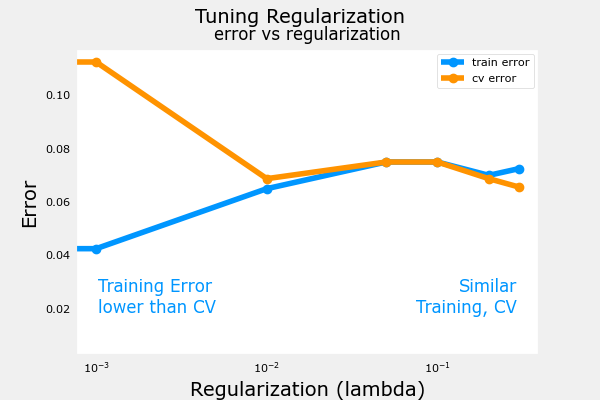

In [45]:
plot_iterate(lambdas, models, X_train, y_train, X_cv, y_cv)

As regularization is increased, the performance of the model on the training and cross-validation data sets converge. For this data set and model, lambda > 0.01 seems to be a reasonable choice.

<a name="7.1"></a>
### 7.1 Test
Let's try our optimized models on the test set and compare them to 'ideal' performance. 

3/3 [==============================] - 0s 820us/step


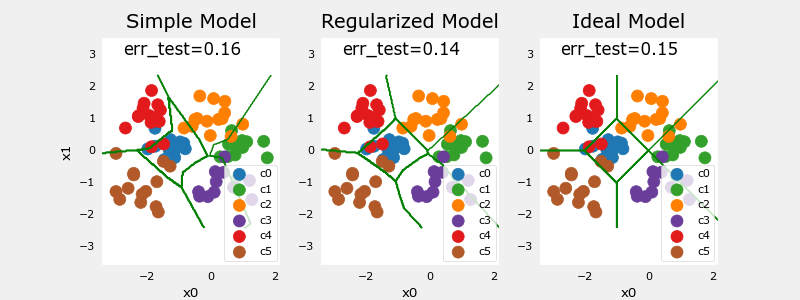

In [46]:
plt_compare(X_test,y_test, classes, model_predict_s, model_predict_r, centers)

Our test set is small and seems to have a number of outliers so classification error is high. However, the performance of our optimized models is comparable to ideal performance.

## Congratulations! 
You have become familiar with important tools to apply when evaluating your machine learning models. Namely:  
* splitting data into trained and untrained sets allows you to differentiate between underfitting and overfitting
* creating three data sets, Training, Cross-Validation and Test allows you to
    * train your parameters $W,B$ with the training set
    * tune model parameters such as complexity, regularization and number of examples with the cross-validation set
    * evaluate your 'real world' performance using the test set.
* comparing training vs cross-validation performance provides insight into a model's propensity towards overfitting (high variance) or underfitting (high bias)